# <center><b>Natural Language Processing with Disaster Tweets</b></center>

# INTRODUCTION
Tweets are short social networking posts broadcasted over the Twitter platform (Wikipedia contributors, 2024). In 2023 the company was purchased by Elon Musk and is now known as X (Wikipedia contributors, 2024). Early detection of disaster events can aid first responders and hasten response time. Huang et al. (2022) has proposed the use of social media posts to help rapidly identify emergency events. The aim of this work is to use natural language processing (NLP) to analyze tweets and predict if they are describing a real disaster

## Reference
Wikipedia contributors. (2024, August 3). Twitter. Wikipedia. https://en.wikipedia.org/wiki/Twitter

Huang, L., Shi, P., Zhu, H., & Chen, T. (2022). Early detection of emergency events from social media: a new text clustering approach. Natural Hazards, 111(1), 851–875. https://doi.org/10.1007/s11069-021-05081-1


### Data
Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

# LIBRAIRIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
import numpy as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2025-05-23 22:20:14.858064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 22:20:14.858273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 22:20:15.016956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# IMPORT AND INSPECT DATA 
There are 7613 tweets in the training data set and 3263 in the test data set. The training data set includes five columns, id which is a unique identifier for each entry, keyword from the tweet, location that the tweet was sent from, text of the tweet and target indicating weather a tweet is about a real disaster (1) or not (0). The test data has the same features minus the target column. There are NaN entries in the location and feature columns in both data sets, and there are no blank entries. 

In [2]:
# Input data files are available in the read-only "../input/" directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print(train.head())
print(test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train.describe(include=object)

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [5]:
print('The dimensions of the training data are:', train.shape)
print('The dimentions of the testing data are:',test.shape)

The dimensions of the training data are: (7613, 5)
The dimentions of the testing data are: (3263, 4)


### NaN Entries

In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

### Blank Entries

In [8]:
(train == '').sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [9]:
(test == '').sum()

id          0
keyword     0
location    0
text        0
dtype: int64

# BASIC DATA CLEANING AND EXPLORATORATION
The features keyword and location have been dropped. Although these could provide useful information for some applications, the goal here is to build a model which predicts disasters based on text and these features are not necessary for this. Looking at the distribution of the target variable approximately 57% of the tweets are not related to a real disaster and approximately 43% of the tweets are flagged as being about a real disaster. The longest tweet in both datasets is 31 words and the length of tweets in both data sets are normally distributed. 

In [10]:
train.drop(columns=['keyword','location'],inplace=True)
test.drop(columns=['keyword','location'],inplace=True)

print(train.head())
print(test.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
print('The dimensions of the training data are:', train.shape)
print('The dimentions of the testing data are:',test.shape)

The dimensions of the training data are: (7613, 3)
The dimentions of the testing data are: (3263, 2)


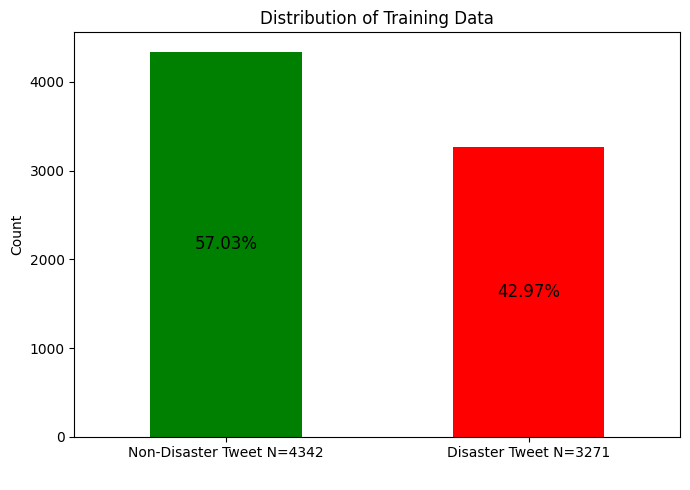

In [12]:
# Get counts of each class
label_counts = train['target'].value_counts()

# Create bar plot
plt.figure(figsize=(7, 5))
ax = label_counts.sort_index().plot(kind='bar', color=['green', 'red'])

plt.xticks([0, 1], labels=[f"Non-Disaster Tweet N={label_counts[0]}", f"Disaster Tweet N={label_counts[1]}"], rotation=0)

for i, count in enumerate(label_counts):
    percentage = count / label_counts.sum() * 100
    # Calculate bar height
    bar_height = count
    # Add percentages
    ax.text(i, bar_height / 2, f'{percentage:.2f}%', ha='center', va='center', fontsize=12)

plt.title(f'Distribution of Training Data')
plt.ylabel('Count')
plt.xlabel(" ")
plt.tight_layout()
plt.show()

In [13]:
# Calculate the length of each tweet 
train['text_length'] = train['text'].apply(lambda x: len(x.split()))
test['text_length'] = test['text'].apply(lambda x: len(x.split()))

# Find the length of the longest tweets
max_train_length = train['text_length'].max()
print(f"The longest tweet in the training set is {max_train_length} words long.")

max_test_length = test['text_length'].max()
print(f"The longest tweet in the test set is {max_test_length} words long.")

The longest tweet in the training set is 31 words long.
The longest tweet in the test set is 31 words long.


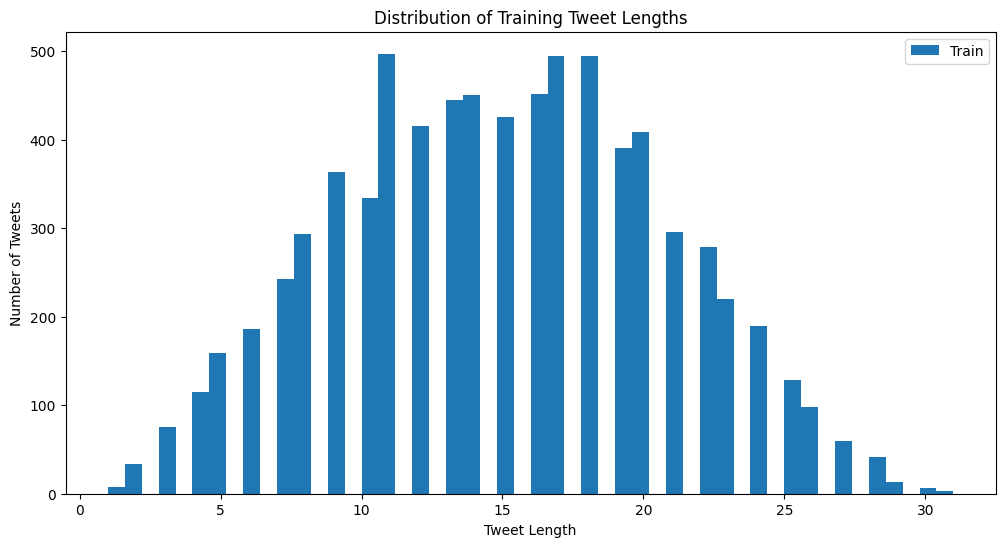

In [14]:
# Distribution of tweet lengths in the training set
plt.figure(figsize=(12, 6))
plt.hist(train['text_length'], bins=50, label='Train')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Training Tweet Lengths')
plt.legend(loc='upper right')
plt.show()

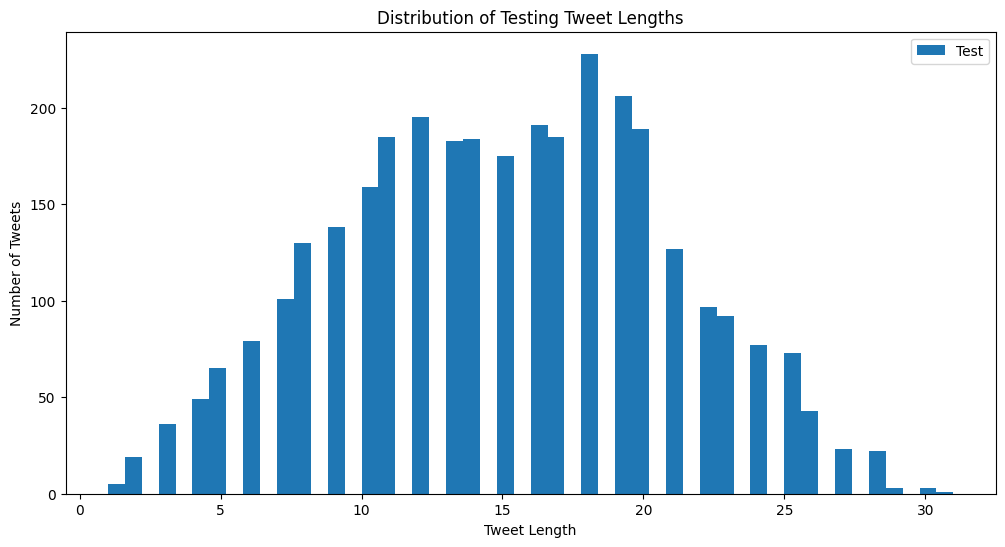

In [15]:
# Distribution of tweet lengths in the testing set
plt.figure(figsize=(12, 6))
plt.hist(test['text_length'], bins=50, label='Test')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Testing Tweet Lengths')
plt.legend(loc='upper right')
plt.show()

# DATA PROCESSING

All text will be converted to lowercase, and punctuation, numbers and non-alphanumeric characters will be removed. Tokenization will be implemented converting the text into a sequence if integers with each number representing a specific word. Tweets will have different lengths so padding will be added because a neural network’s inputs must be of the same size. The resulting processed data sets will be NumPy arrays with rows of padded numeric sequences of equal lengths. 


## Tweet Cleaning

Look into lemmatization with nltk.

Check into using spaCy's lemmatizer:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_lemmatizer(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# load stop words
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def tweet_cleaner(text, keep_hashtags=True, keep_mentions=False, 
                custom_stopwords=None, apply_stemming=True):
    """
    Cleans tweets before tokenization
    """
    # Lowercase and trim whitespace
    text = text.lower().strip()
    
    # Replace numbers with a token
    text = re.sub(r'\d+', ' NUMBER ', text)
    
    # Replace punctuation 
    text = text.replace('!', ' EXCLAMATION ')
    text = text.replace('?', ' QUESTION ')
    #text = text.replace('#', ' HASHTAG ')
    
    # Hashtags 
    if keep_hashtags:
        # Extract hashtag content, preserve the meaningful word
        text = re.sub(r'#(\w+)', r'\1', text)
    else:
        # Remove hashtags completely
        text = re.sub(r'#\w+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML entities
    text = re.sub(r'&\w+;', '', text)
    
    # Remove non-alphabetic characters EXCEPT space
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    words = text.split()

    # Remove stopwords
    if custom_stopwords is None:
        custom_stopwords = stop_words
    words = [word for word in words if word not in custom_stopwords]
    
    # Apply stemming if requested
    if apply_stemming:
        words = [stemmer.stem(word) for word in words]
        
    return ' '.join(words)
    

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [17]:
# Clean training tweets
train['clean_text'] = train['text'].apply(tweet_cleaner)
print(train[['text', 'clean_text']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0          deed reason earthquak may allah forgiv us  
1               forest fire near la rong sask canada  
2  resid ask shelter place notifi offic evacu she...  
3  number number peopl receiv wildfir evacu order...  
4  got sent photo rubi alaska smoke wildfir pour ...  


In [18]:
# Clean testing tweets
test['clean_text'] = test['text'].apply(tweet_cleaner)
# Inspect
print(test[['text', 'clean_text']].head())

                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typhoon Soudelor kills 28 in China and Taiwan   

                                          clean_text  
0                           happen terribl car crash  
1      heard earthquak differ citi stay safe everyon  
2  forest fire spot pond gees flee across street ...  
3                     apocalyps light spokan wildfir  
4          typhoon soudelor kill number china taiwan  


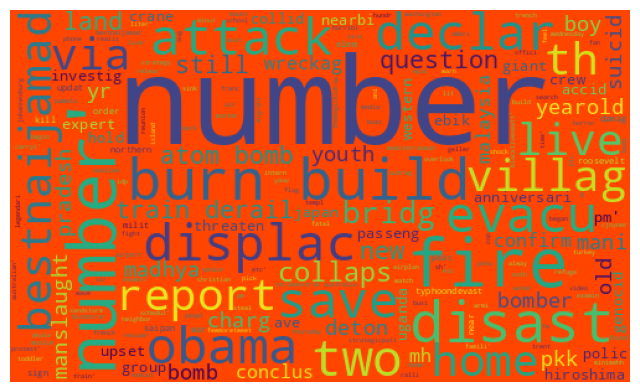

In [29]:
from collections import Counter
from wordcloud import WordCloud

def make_dict(tup, dictionary):
    for x, y in tup:
        dictionary.setdefault(x, []). append(y)
    return dictionary
count = Counter(list(train[train['target']==1]['clean_text']))
top_words_disaster = {}
make_dict(count.most_common(50), top_words_disaster)
df = pd.DataFrame.from_dict(top_words_disaster, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'orangered', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Disaster Keywords', fontsize = 22)
# save plot (optional)
#plt.savefig('/kaggle/working/disaster_keywords.png', bbox_inches = 'tight',facecolor='white', transparent =None)
plt.show()

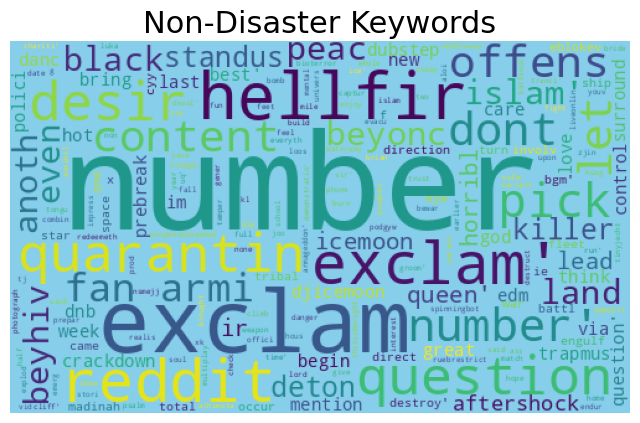

In [24]:
def make_dict(tup, dictionary):
    for x, y in tup:
        dictionary.setdefault(x, []). append(y)
    return dictionary
count = Counter(list(train[train['target']==0]['clean_text']))
top_words_nondisaster = {}
make_dict(count.most_common(50), top_words_nondisaster)
df = pd.DataFrame.from_dict(top_words_nondisaster, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'skyblue', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Non-Disaster Keywords', fontsize = 22)
# save plot (optional)
#plt.savefig('/kaggle/working/nondisaster_keywords.png', bbox_inches = 'tight',facecolor='white', transparent =None)
plt.show()

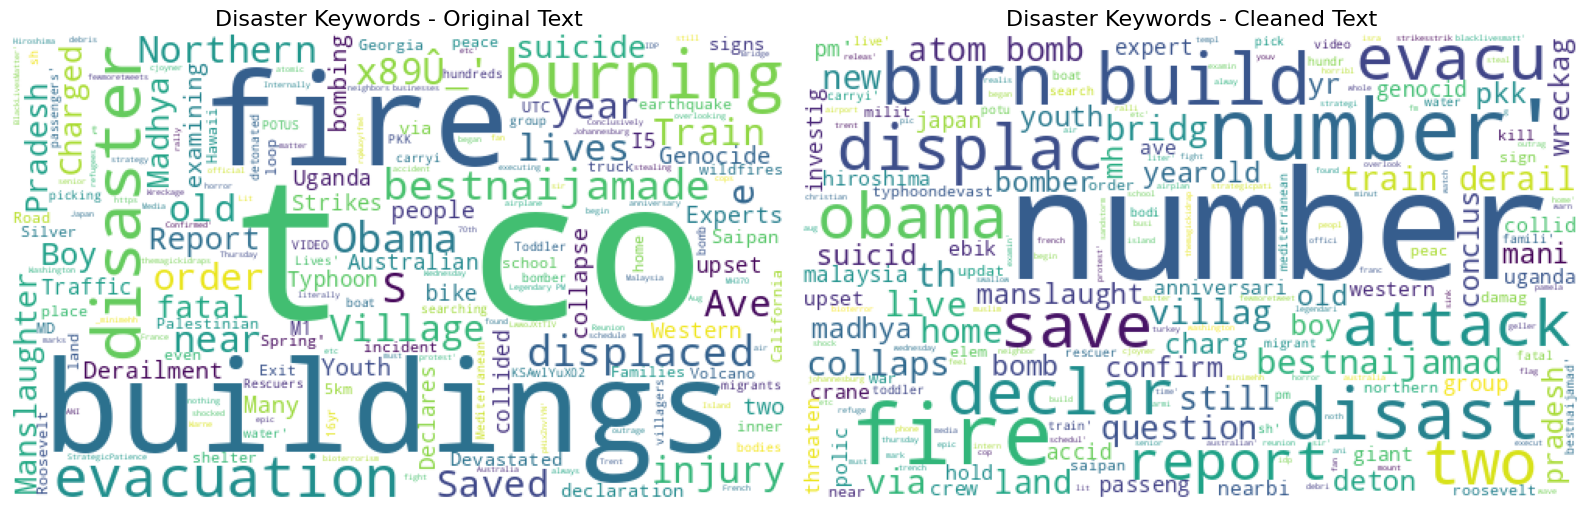

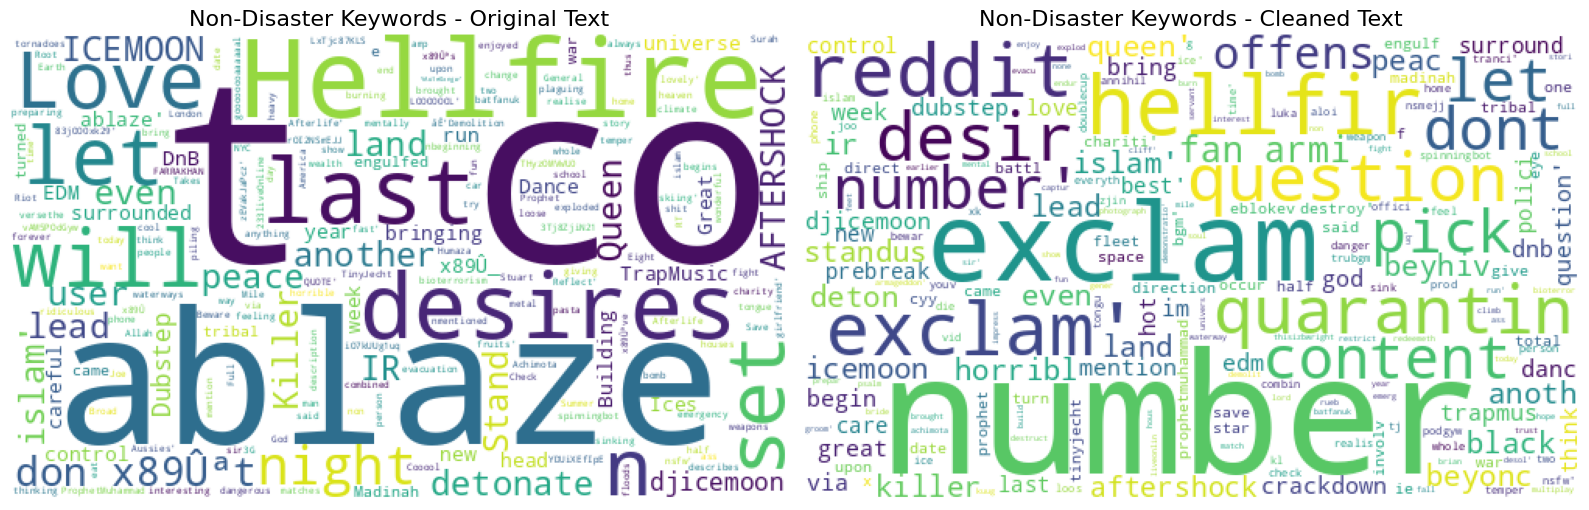

In [28]:
def make_dict(tup, dictionary):
    for x, y in tup:
        dictionary.setdefault(x, []). append(y)
    return dictionary

def create_wordcloud_comparison(train_data, target_value=1, title_prefix=""):
    # Create word cloud for original text
    count_original = Counter(list(train_data[train_data['target']==target_value]['text']))
    top_words_original = {}
    make_dict(count_original.most_common(50), top_words_original)
    df_original = pd.DataFrame.from_dict(top_words_original, orient='index').reset_index()
    df_original.columns = ['word', 'count']
    text_original = df_original['word'].values
    
    # Create word cloud for cleaned text
    # Apply the tweet_cleaner 
    train_data['cleaned_text'] = train_data['text'].apply(tweet_cleaner)
    
    count_cleaned = Counter(list(train_data[train_data['target']==target_value]['cleaned_text']))
    top_words_cleaned = {}
    make_dict(count_cleaned.most_common(50), top_words_cleaned)
    df_cleaned = pd.DataFrame.from_dict(top_words_cleaned, orient='index').reset_index()
    df_cleaned.columns = ['word', 'count']
    text_cleaned = df_cleaned['word'].values
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=100)
    
    # Original word cloud
    wordcloud_original = WordCloud(background_color='white', width=500, height=300, 
                                 collocations=True).generate(str(text_original))
    ax1.imshow(wordcloud_original)
    ax1.axis('off')
    ax1.set_title(f'{title_prefix} Keywords - Original Text', fontsize=16)
    
    # Cleaned word cloud
    wordcloud_cleaned = WordCloud(background_color='white', width=500, height=300, 
                                collocations=True).generate(str(text_cleaned))
    ax2.imshow(wordcloud_cleaned)
    ax2.axis('off')
    ax2.set_title(f'{title_prefix} Keywords - Cleaned Text', fontsize=16)
    
    plt.tight_layout()
    # save wordcloud (optional)
    #plt.savefig(f'/kaggle/working/{title_prefix.lower()}_keywords_comparison.png', 
                bbox_inches='tight', facecolor='white', transparent=None)
    plt.show()

# Create comparison for disaster tweets (target=1)
create_wordcloud_comparison(train, target_value=1, title_prefix="Disaster")

# Create comparison for non-disaster tweets (target=0)
create_wordcloud_comparison(train, target_value=0, title_prefix="Non-Disaster")

## Tokenization and Padding

Unstructured text data, such as tweets, are difficult for computers to interpret. Tokenization adresses this by breaking down the text into small units called tokens.

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fit the tokenizer on the cleaned training tweets
tokenizer = Tokenizer(num_words=3500, oov_token="<OOV>")
tokenizer.fit_on_texts(train['clean_text'])

# Convert cleaned text to sequences of numbers
train_sequences = tokenizer.texts_to_sequences(train['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])  # if test has also been cleaned

# Set the maximum length for sequence padding
max_length = 40

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# inspect
print('The dimensions of the padded training data are: ',train_padded.shape)
print('The dimensions of the padded testing data are: ',test_padded.shape)

print('The training data after tokenization and padding')
print(train_padded[:2])
print('The testing data after tokenization and padding')
print(test_padded[:2])

The dimensions of the padded training data are:  (7613, 40)
The dimensions of the padded testing data are:  (3263, 40)
The training data after tokenization and padding
[[   1  486  234   98 1397 3063   21    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 159    6  210  487    1    1 1067    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
The testing data after tokenization and padding
[[ 211 1721   61   23    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 413  234  853  146  434 1290  202    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  

# MODELS
Now that the tweets are appropriately formatted to be feed into a neural network the models will be constructed. For this problem recurrent neural networks (RNNs) will be used. RNNs are a good choice for this task because they retain information about previous inputs to influence the current input and subsequent output (What Are Recurrent Neural Networks? | IBM, n.d.). Making RNNs well suited for analyzing sequential data and for tasks such as NLP (What Are Recurrent Neural Networks? | IBM, n.d.).

**Reference**

What are Recurrent Neural Networks? | IBM. (n.d.). IBM. https://www.ibm.com/topics/recurrent-neural-networks

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, GRU, Dense, BatchNormalization, Masking, Dropout, SpatialDropout1D, ActivityRegularization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall

## Class to Calculate the F1 Score
F1 scores will be used to evaluate submissions.This class was created to calculate the F1 score for plotting.  

In [32]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
    
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

## Function for Plotting Accuracy, Loss, and F1 score

In [33]:
def model_perfromance_plots(history, model_name, save = False):
    """
    Plot the accuracy, loss, and F1 score from the training history.
    
    Inputs: 
    history - the history of the fit method of the model
    model_name - the name of the model
    save - boolean, save the plot 
    """

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend(loc='upper right')

    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1_score'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'{model_name} F1 Score')
    plt.legend(loc='lower right')

    plt.tight_layout()

    if save:
        plt.savefig(f"/kaggle/working/{model_name}.png")
        
    plt.show()

In [34]:
# define target
target = train['target'].values

print(train_padded.shape)
print(target.shape)

(7613, 40)
(7613,)


## Learning Rate Schedulers & Early Stopping

- Reduces the learning rate during training if learning stalls

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor ='val_loss', # evaluate validation loss
    factor = 0.1, # amount to multiply the lr by to reduce
    patience = 2, # number of epochs to wait w/out change before reducing
    min_lr = 1.0e-6, # lower bound of lr, not to go below
    verbose = 1 # print out when lr is reduced
)



In [36]:
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

initial_learning_rate = 0.001
first_decay_steps = 1000

lr_schedule = CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps,
    t_mul=2.0,  # multiplier for each restart cycle
    m_mul=0.9,  # multiplier for learning rate at each restart
    alpha=0.0   # minimum learning rate value as a fraction of initial_learning_rate
)


In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,  # Stop earlier
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=4
)


## Simple RNN Model Architecture
The first layer of the model is an Embedding layer, which helps to reduce the dimensionality of the data by mapping each word to a lower dimensional space. Next a SpatialDropout layer was included to help with overfitting. The Masking layer is included so the model ignores any added padding. Next is the SimpleRNN layer with 64 units. The final dense layer includes a sigmoid output function that is appropriate for binary classification.

### Different types of droupout used in models:
- **SpatialDropout**
    - Applied to the embedding layer.
    - Drops entire 1D embedding vectors.
    - Helps prevent overfitting by encouraging the model not to focus on specific word embeddings.
- **Recurrent Dropout**
    - Drops connections within the LSTM’s recurrent memory during training.
    - Helps regularize temporal depenencies.
- **Dropout Layers**
    - Generic dropout layers added after LSTM layers.
    - Helps with overfitting by randomly zeroing activations.
- **ActivityRegularization**
    - Adds a penalty to the magnitude of activations.
    - Encourages the model to produce smaller activations, which can help reduce overfitting.

In [51]:
# Clear the previous session
tf.keras.backend.clear_session()

In [52]:
simple_rnn_model = Sequential([
    Embedding(input_dim=3500, output_dim=16), # Set input_dim equal to tokenizer num_words
    SpatialDropout1D(0.8),
    Masking(mask_value=0),  # Ignore padding
    SimpleRNN(64),  
    Dropout(0.5), 
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Sigmoid activation for binary classification
])

# compile the model with F1 score
simple_rnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', F1Score()])


In [53]:
# train the model
hist_simple_rnn = simple_rnn_model.fit(
    train_padded,
    target, 
    epochs=24,
    batch_size=64, 
    validation_split=0.2,
    callbacks = [reduce_lr]
)

Epoch 1/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5338 - f1_score: 0.3050 - loss: 0.7127 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 2/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5807 - f1_score: 0.1870 - loss: 0.6936 - val_accuracy: 0.5364 - val_f1_score: 0.0112 - val_loss: 0.7006 - learning_rate: 0.0010
Epoch 3/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5930 - f1_score: 0.2577 - loss: 0.6811 - val_accuracy: 0.7006 - val_f1_score: 0.5607 - val_loss: 0.6144 - learning_rate: 0.0010
Epoch 4/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6769 - f1_score: 0.5720 - loss: 0.6178 - val_accuracy: 0.7564 - val_f1_score: 0.7090 - val_loss: 0.5504 - learning_rate: 0.0010
Epoch 5/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7487 - f1_score: 0.6758 - loss: 0.5476 - val_accuracy: 0.7689 - val_f1_score: 0.7057 - val_loss: 0.5359 - learning_rate: 0.0010
Epoch 6/24
96/96 ━━━━━━━━━━━━━━

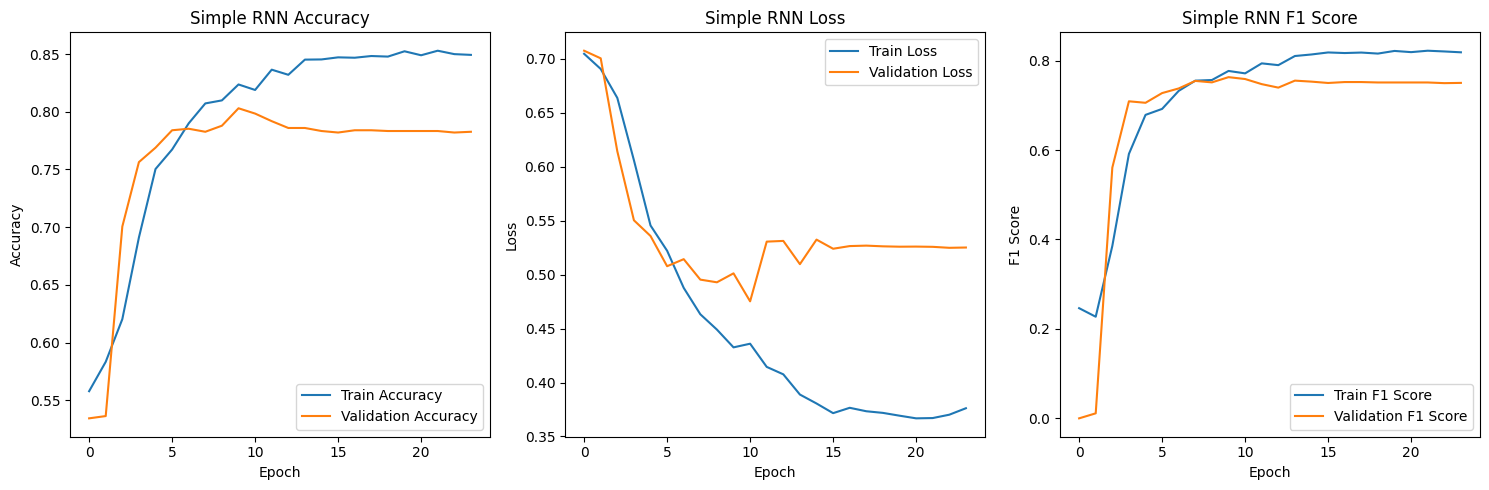

In [54]:
# Plot results
simple_rnn_performance_plots = model_perfromance_plots(hist_simple_rnn, "Simple RNN", save=False)

simple_rnn_performance_plots

## Simple RNN Model Results
Although this model performed well with the training data it can be seen in the performance plots that the model did not handel the validation well. From the loss plot it appears that there is a problem with overfitting. 


## RNN Model Architecture
This model has much of the same architecture as the simple RNN model. One difference is that a second SimpleRNN layer with 4 neurons was added after the first SimpleRNN layer. Also, kernel regularization was added to dense output layer to help the model converge properly. 

In [47]:
# Clear the previous session
tf.keras.backend.clear_session()

In [48]:
rnn_model = Sequential([
    Embedding(input_dim = 3500, output_dim = 16),
    SpatialDropout1D(0.8),
    Masking(mask_value=0),  # Ignore padding
    SimpleRNN(64, return_sequences = True),
    SimpleRNN(64),  
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Sigmoid activation for binary classification
])

# compile the model with F1 score
rnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', F1Score()])


In [49]:
# train the model
hist_rnn = rnn_model.fit(
    train_padded,
    target, 
    epochs=24,
    batch_size=64, 
    validation_split=0.2,
    callbacks = [reduce_lr]
)

Epoch 1/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5375 - f1_score: 0.3357 - loss: 1.2327 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.9416 - learning_rate: 0.0010
Epoch 2/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5758 - f1_score: 0.1008 - loss: 0.8781 - val_accuracy: 0.5371 - val_f1_score: 0.0167 - val_loss: 0.7698 - learning_rate: 0.0010
Epoch 3/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5842 - f1_score: 0.2885 - loss: 0.7439 - val_accuracy: 0.5804 - val_f1_score: 0.3351 - val_loss: 0.7016 - learning_rate: 0.0010
Epoch 4/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6554 - f1_score: 0.5108 - loss: 0.6627 - val_accuracy: 0.7413 - val_f1_score: 0.6695 - val_loss: 0.5828 - learning_rate: 0.0010
Epoch 5/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7236 - f1_score: 0.6550 - loss: 0.5962 - val_accuracy: 0.7531 - val_f1_score: 0.6696 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 6/24
96/96 ━━━━━━━━━━━━━━

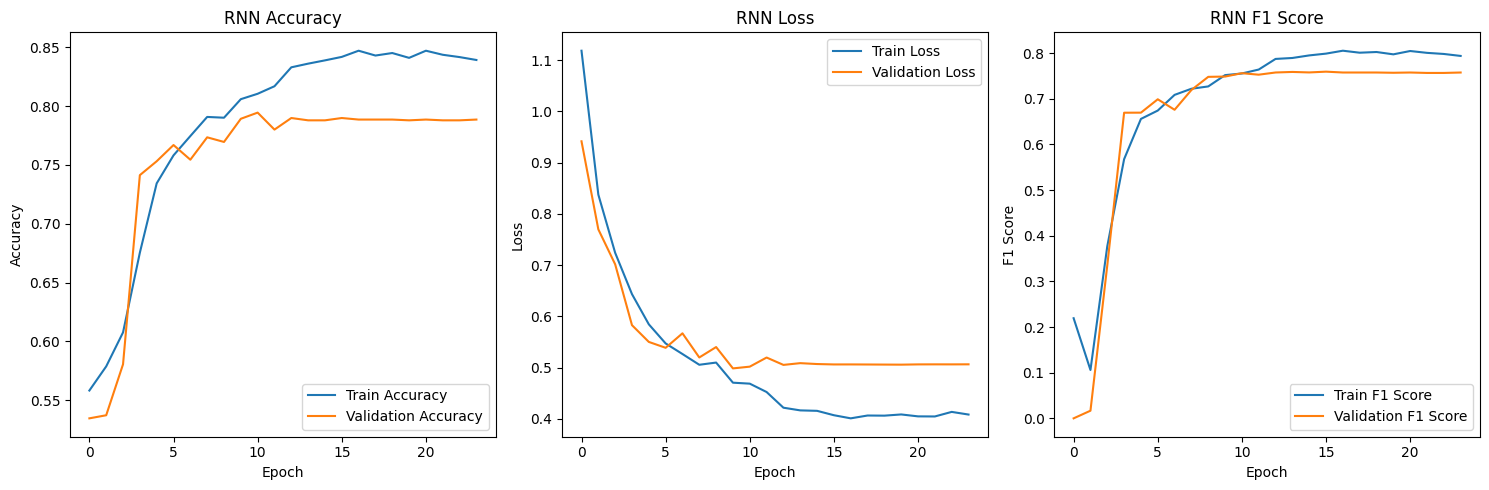

In [50]:
# Plot results
rnn_performance_plots = model_perfromance_plots(hist_rnn, "RNN", save=False)
rnn_performance_plots


## RNN Model Results
This model performed much better than the simple RNN model. Examining the performance plots, it is easy to see that this model is working much better with the validation data than the simple RNN model did. There is much less of a gap in the loss plots of the training and validation data. However, there is still room for improvement. 


## Bidirectional LSTM Model Architecture
LSTM stands for Long Short-Term Memory and are more complicated than simple RNNs. LSTM models learn long-term dependencies and can remember information from longer sequences but are more computationally taxing. The model here will use the same architecture as the second RNN with LTSM layers in place of the SimpleRNN layers and multiple dropout layers are added. 

      

In [ ]:
# Clear the previous session
tf.keras.backend.clear_session()

In [39]:
lstm_model = Sequential([
    Embedding(input_dim = 3500, output_dim = 16),
    SpatialDropout1D(0.85),  
    Masking(mask_value=0),  # Ignore padding
    Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.3)), # , recurrent_dropout=0.3
    Dropout(0.2), 
    Bidirectional(LSTM(64, recurrent_dropout=0.3)), #, recurrent_dropout=0.3
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    # Optional: Add activity regularization instead of dropout
    #ActivityRegularization(l1=0.0001, l2=0.0001),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.01)) # sigmoid activation for binary classification
])


# compile the model with F1 score
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', F1Score()])


# Uncomment out to compile model with Cosine Delay, and comment out above complier
"""
# compile the model with F1 score and CosineDecayRestarts
optimizer = Adam(learning_rate=lr_schedule)
lstm_model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', F1Score()])
"""


"\n# compile the model with F1 score and CosineDecayRestarts\noptimizer = Adam(learning_rate=lr_schedule)\nlstm_model.compile(optimizer=optimizer,\n                  loss='binary_crossentropy',\n                  metrics=['accuracy', F1Score()])\n"

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_padded, target, test_size = 0.2, random_state=42)

In [41]:
hist_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs = 24,
    batch_size = 64,
    validation_data = (X_val, y_val),
    callbacks = [reduce_lr]
)

Epoch 1/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.5442 - f1_score: 0.3451 - loss: 1.4222 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00 - val_loss: 1.0271 - learning_rate: 0.0010
Epoch 2/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6321 - f1_score: 0.4862 - loss: 0.9191 - val_accuracy: 0.6513 - val_f1_score: 0.3095 - val_loss: 0.7942 - learning_rate: 0.0010
Epoch 3/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.7087 - f1_score: 0.6198 - loss: 0.6819 - val_accuracy: 0.7420 - val_f1_score: 0.5824 - val_loss: 0.6653 - learning_rate: 0.0010
Epoch 4/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.7513 - f1_score: 0.6750 - loss: 0.5569 - val_accuracy: 0.7997 - val_f1_score: 0.7235 - val_loss: 0.5634 - learning_rate: 0.0010
Epoch 5/24
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.7835 - f1_score: 0.7172 - loss: 0.4967 - val_accuracy: 0.8037 - val_f1_score: 0.7366 - val_loss: 0.5183 - learning_rate: 0.0010
Epoch 6/24
96/96 ━━━━━━━━

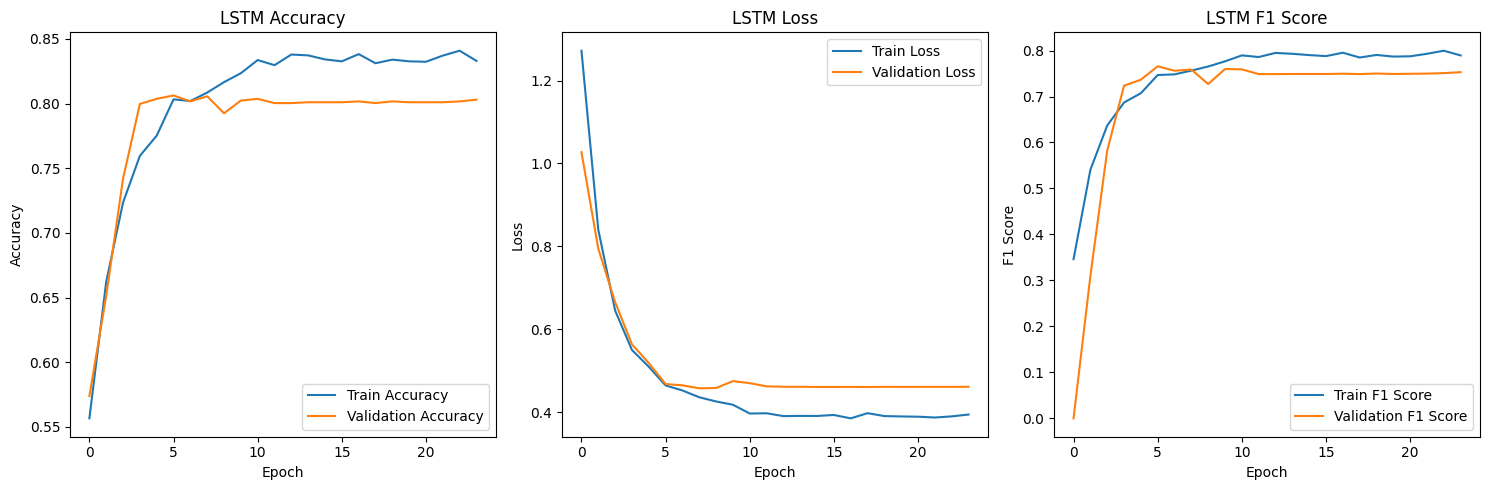

In [46]:
# Plot results
lstm_performance = model_perfromance_plots(hist_lstm, "LSTM", save=False)
lstm_performance

## Confusion Matrix for Bidirectional Model

In [44]:
# Calculate predicted probabilities
y_probs = lstm_model.predict(X_val)

# Convert probabilities to binary
y_preds = (y_probs >= 0.5).astype(int)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

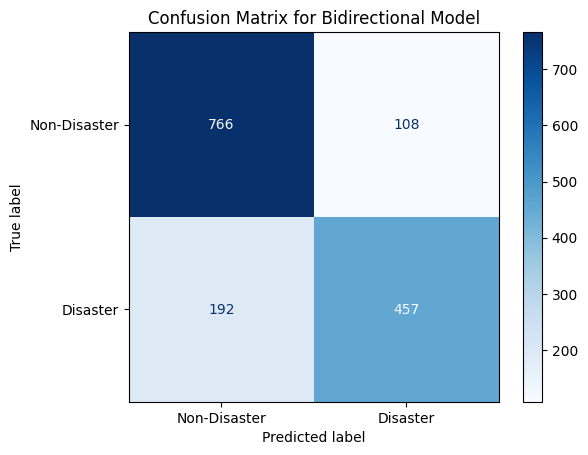

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_lstm = confusion_matrix(y_val, y_preds)

disp_cm_lstm = ConfusionMatrixDisplay(
    confusion_matrix= cm_lstm, 
    display_labels = ["Non-Disaster", "Disaster"]
)
disp_cm_lstm.plot(cmap = 'Blues')
plt.title("Confusion Matrix for Bidirectional Model")
# save confusion matrix (optional)
plt.savefig('/kaggle/working/confusion_matrix_bidirectional.png')
plt.show

# SUBMISSION

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

In [ ]:
# Make predictions on the test data
test_preds = lstm_model.predict(test_padded)

# Convert predictions to binary labels (0 or 1)
test_preds = (test_preds > 0.5).astype(int)

In [ ]:
# Prepare the submission 
submission = pd.DataFrame({'id': sample_submission['id'], 'target': test_preds.flatten()})

# Save the submission 
submission.to_csv('submission.csv', index=False)

# Inspect
submission.head()

# CONCLUSION

The main challenge with building these networks is that several parameters needed to be optimized for the models to perform well. The spatial dropout layer had a powerful impact. I was surprised that the dropout rate had to be set very high to avoid overfitting. Dropout rates from 10% to 90% were tested with a rate of 80% being the best. Also, the size of the vocabulary impacted model performance. Models were assessed with the size of the vocabulary set between10,000 and 250 words. All models performed better with moderate sized vocabulary between 2,500 and 5000 words. The number of units in the neuronal layers was impactful, with models having 64 units seemed optimal. Also, implementing a learning rate scheduler help stabilize training. 

One method that could be looked at in the future to improve model performance is synonym replacement. This is a data augmentation technique which randomly chooses words and replaces them with a randomly chosen synonym (Monitsky, 2023). Another augmentation technique that could be used to enhance model performance is back translation. This is where some text is translated into a different language then back to its original language (Monitsky, 2023). Both techniques have been shown to work well with NLP tasks. Developing a strategy to address emojis during text cleaning could enhance model performance as well. 

**Reference**

Monitsky, V. (2023, November 7). Data augmentation for natural language Processing - Vince Monitsky - Medium. Medium. https://medium.com/@vmn11/data-augmentation-for-natural-language-processing-e718f53e387f

https://medium.com/codex/natural-language-processing-cleaning-up-tweets-2b71793e91b5
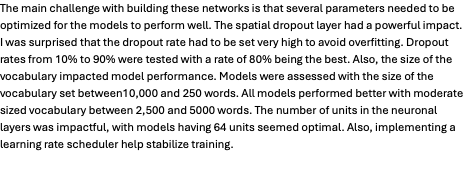
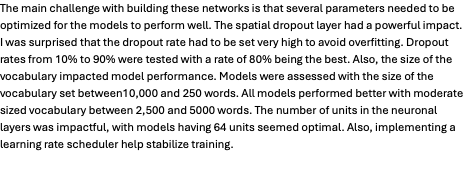
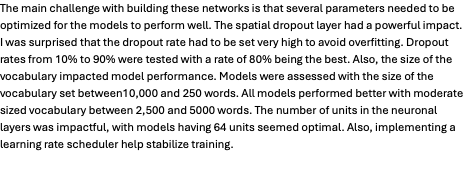
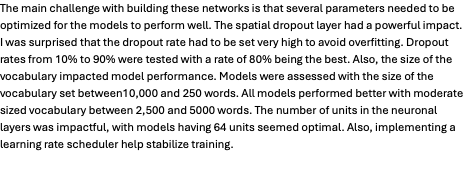
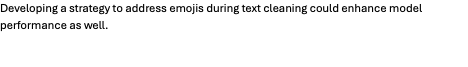
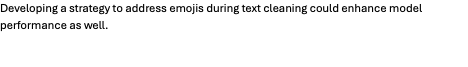
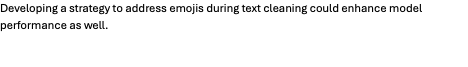
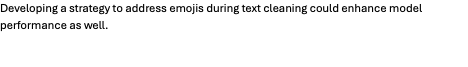